In [ ]:
%%capture
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os

anomaly_classes = os.listdir('/kaggle/input/mvtec-ad')
anomaly_classes = [cl for cl in anomaly_classes if '.txt' not in cl]
anomaly_classes

['wood',
 'screw',
 'metal_nut',
 'capsule',
 'hazelnut',
 'carpet',
 'pill',
 'grid',
 'zipper',
 'transistor',
 'tile',
 'leather',
 'toothbrush',
 'bottle',
 'cable']

In [ ]:
len(os.listdir('/kaggle/input/mvtec-ad/' + anomaly_classes[2] + '/train/good'))

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torchvision
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.models import vgg19

from PIL import Image

import glob
from tqdm import tqdm
import random
import os

from sklearn.decomposition import PCA

In [4]:
class MVTec(Dataset):
    def __init__(self, dir_path = '/kaggle/input/mvtec-ad', train=True, tfms=None):
        self.anomaly_classes = 'pill'
        self.dir_path = dir_path
        self.tfms = tfms
        self.train = train
        if self.train:
            self.data_path = glob.glob(os.path.join(dir_path, self.anomaly_classes, 'train', 'good', '*'))
        else:
            self.data_path = glob.glob(os.path.join(dir_path, self.anomaly_classes, 'test', '*', '*'))
    
    def __len__(self):
        return len(self.data_path)
    
    def __getitem__(self, idx):
        img = Image.open(self.data_path[idx]).convert('RGB')
        if self.tfms is None:
            self.tfms = Compose([
                Resize(size=(224, 224)),
                ToTensor()
            ])
        img = self.tfms(img)
        if self.train: 
            return img.float()
        else:
            label = int(self.data_path[idx].split('/')[-2] != 'good') # good : 0, anomaly: 1
            return img.float(), label

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, co, cd) -> None:
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=co, out_channels=(co + cd)//2, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=(co + cd)//2, out_channels=2*cd, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=2*cd, out_channels=cd, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=cd, out_channels=2*cd, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=2*cd, out_channels=(co + cd)//2, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=(co + cd)//2, out_channels=co, kernel_size=(1, 1)),
        )
    
    def forward(self, fx):
        return self.features(fx)

In [9]:
class FeatureExtractor(nn.Module):
    def __init__(self, input_size = (224, 224)):
        super().__init__()
        self.out_features = []
        self.backbone = vgg19(pretrained=True).features
        
        for m in self.backbone.children():
            if isinstance(m, nn.Conv2d):
                m.register_forward_hook(self.hook)
        
        self.relu = nn.ReLU()
        self.up_sample = nn.Upsample(size=input_size)
        self.avg_pool = nn.AvgPool2d(kernel_size=(4, 4), stride=4)
        # self.num_out_features = sum([feature.shape[1] for feature in self.get_features(torch.randn(1, 3, *input_size))])
    
    def forward(self, x):
        _ = self.backbone(x)
        out_features = torch.cat([self.avg_pool(self.up_sample(self.relu(feature))) for feature in self.out_features], dim=1)
        self.out_features.clear()
        return out_features
    
    def hook(self, module, input, output):
        self.out_features.append(output.detach())

In [ ]:
# /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
# FeatureExtractor()(torch.randn(2, 3, 256, 256)).shape

In [21]:
class DFR(nn.Module):
    def __init__(self, latent_dim = 321):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        
        for m in self.feature_extractor.parameters():
            m.requires_grad = False
        
        self.auto_encoder = AutoEncoder(co = 5504,
                                       cd = latent_dim)

        self.threshold = None
    
    def forward(self, x):
        gt_feature = self.feature_extractor(x)
        pred_feature = self.auto_encoder(gt_feature)
        return gt_feature, pred_feature
 
    def loss_function(self, y_pred, y_true):
        return torch.mean((y_pred - y_true)**2)
    
    def calculate_map(self, y_pred, y_true):
        return torch.mean((y_pred - y_true)**2, dim=1)

    def compute_threshold(self, dataloader, fpr = 0.05):
        error = []
        with tqdm(enumerate(train_dl), total=len(train_dl)) as tqdm_loader:
            for idx, X in tqdm_loader:
                with torch.no_grad():
                    gt_feature, pred_feature = model(X.cuda())
                score = model.calculate_map(pred_feature, gt_feature)
                error.append(score.detach().cpu().numpy())
        
        self.threshold = np.percentile(error, 100 - fpr)
    
    def compute_pca(self, dataloader):
        extract_per_sample = 20
        extractions = []
        with tqdm(enumerate(dataloader), total=len(dataloader)) as tqdm_loader:
            for idx, X in tqdm_loader:
                with torch.no_grad():
                    out_features = self.feature_extractor(X.cuda())
                for feature in out_features:
                    for _ in range(extract_per_sample):
                        row, col = random.randrange(feature.shape[1]), random.randrange(feature.shape[2])
                        extraction = feature[:, row, col]
                        extractions.append(extraction.detach().cpu().numpy())
        
        extractions = np.stack(extractions)
        print(f'Extractions shape: {extractions.shape}')
        pca = PCA(0.9, svd_solver="full")
        pca.fit(extractions)
        cd = pca.n_components_
        print(f"Components with explainable variance 0.9 -> {cd}")

In [11]:
# mvtec_train = MVTec()
# print(len(mvtec_train))

# train_dl = DataLoader(mvtec_train, batch_size=4, num_workers=os.cpu_count())

# DFR().cuda().compute_pca(train_dl)

267


100%|██████████| 67/67 [00:08<00:00,  8.19it/s]


Extractions shape: (5340, 5504)
Components with explainable variance 0.9 -> 228


In [25]:
model = DFR(latent_dim = 228).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [43]:
def train(dataloader, model, optimizer):
    model.train()
    losses = 0
    for x in dataloader:
        gt_feature, pred_feature = model(x.cuda())
        loss = model.loss_function(pred_feature, gt_feature)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += loss.item()
    losses /= len(train_dl)
    return losses

def evaluate(dataloader, model):
    model.eval()
    acc = []
    loss_eval = 0
    for X, label in dataloader:
        with torch.no_grad():
            gt_feature, pred_feature = model(X.cuda())
            loss = model.loss_function(pred_feature, gt_feature)
        heatmap = model.calculate_map(pred_feature, gt_feature)
        # 0: good, 1: anomaly
        prediction = torch.any((heatmap > model.threshold).view(heatmap.size(0), -1), dim=-1).int()
        loss_eval += loss.item()
        acc.extend(prediction.detach().cpu().eq(label).numpy().tolist())
    acc = np.mean(acc)
    loss_eval /= len(dataloader)
    return acc, loss_eval

In [37]:
mvtec_train = MVTec(train=True)
mvtec_test = MVTec(train=False)
print(len(mvtec_train))
print(len(mvtec_test))

train_dl = DataLoader(mvtec_train, batch_size=8, num_workers=os.cpu_count(), shuffle=True, pin_memory=True, drop_last=True)
test_dl = DataLoader(mvtec_test, batch_size=8, num_workers=os.cpu_count(), shuffle=False, pin_memory=True)

267
167


In [44]:
for epoch in range(700):
    loss_train = train(train_dl, model, optimizer)
    model.eval()
    model.compute_threshold(train_dl, fpr=0.05)
    acc, loss_eval = evaluate(test_dl, model)
    print(f'Epoch: {epoch} - Train Loss: {loss_train} - Val Loss: {loss_eval} - Val Accuracy: {acc}')

100%|██████████| 33/33 [00:10<00:00,  3.05it/s]


Epoch: 0 - Train Loss: 0.06846133653413165 - Val Loss: 0.0863394985596339 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.95it/s]


Epoch: 1 - Train Loss: 0.06804393164136192 - Val Loss: 0.0859284404487837 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 2 - Train Loss: 0.06790567291053859 - Val Loss: 0.08587466925382614 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.95it/s]


Epoch: 3 - Train Loss: 0.06774341439207394 - Val Loss: 0.08566723054363615 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 4 - Train Loss: 0.067511903517174 - Val Loss: 0.0853080479871659 - Val Accuracy: 0.7544910179640718


100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


Epoch: 5 - Train Loss: 0.06724801467675151 - Val Loss: 0.08510511297555197 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.05it/s]


Epoch: 6 - Train Loss: 0.06705333416660626 - Val Loss: 0.08483920175404776 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 7 - Train Loss: 0.06695482676679437 - Val Loss: 0.0849560939130329 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.03it/s]


Epoch: 8 - Train Loss: 0.06655482315655911 - Val Loss: 0.08428535504000527 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.96it/s]


Epoch: 9 - Train Loss: 0.06644778506773891 - Val Loss: 0.084119620599917 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


Epoch: 10 - Train Loss: 0.06635430127833829 - Val Loss: 0.08469575501623608 - Val Accuracy: 0.7544910179640718


100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


Epoch: 11 - Train Loss: 0.06609099222855135 - Val Loss: 0.08366140652270544 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.01it/s]


Epoch: 12 - Train Loss: 0.06565717438405211 - Val Loss: 0.08348041843800318 - Val Accuracy: 0.7544910179640718


100%|██████████| 33/33 [00:10<00:00,  3.03it/s]


Epoch: 13 - Train Loss: 0.06572124949007323 - Val Loss: 0.08324005277383895 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.05it/s]


Epoch: 14 - Train Loss: 0.0654356437876369 - Val Loss: 0.08317418662565094 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.98it/s]


Epoch: 15 - Train Loss: 0.06535214851751472 - Val Loss: 0.08286188667019208 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 16 - Train Loss: 0.06518496166576039 - Val Loss: 0.08270426289666266 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 17 - Train Loss: 0.0648073468244437 - Val Loss: 0.08240470467578798 - Val Accuracy: 0.7544910179640718


100%|██████████| 33/33 [00:11<00:00,  2.98it/s]


Epoch: 18 - Train Loss: 0.0646010297491695 - Val Loss: 0.08239003146688144 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 19 - Train Loss: 0.06457162693594441 - Val Loss: 0.08233119050661723 - Val Accuracy: 0.7544910179640718


100%|██████████| 33/33 [00:10<00:00,  3.05it/s]


Epoch: 20 - Train Loss: 0.06425174844987465 - Val Loss: 0.0820217194656531 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.99it/s]


Epoch: 21 - Train Loss: 0.06426861724167159 - Val Loss: 0.08173660259871256 - Val Accuracy: 0.7544910179640718


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 22 - Train Loss: 0.06385714865543625 - Val Loss: 0.08175803738690558 - Val Accuracy: 0.7485029940119761


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 23 - Train Loss: 0.06393454991506808 - Val Loss: 0.08142109321696418 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.96it/s]


Epoch: 24 - Train Loss: 0.06366251996069243 - Val Loss: 0.08118140041118577 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


Epoch: 25 - Train Loss: 0.06333301103476321 - Val Loss: 0.08109309542037192 - Val Accuracy: 0.7544910179640718


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 26 - Train Loss: 0.06339586401979129 - Val Loss: 0.08077903659570784 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.93it/s]


Epoch: 27 - Train Loss: 0.06299018882440799 - Val Loss: 0.08069590851664543 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.05it/s]


Epoch: 28 - Train Loss: 0.06296592126741554 - Val Loss: 0.08042010647200402 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


Epoch: 29 - Train Loss: 0.06281445164120558 - Val Loss: 0.08048993012025243 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 30 - Train Loss: 0.06267033438339378 - Val Loss: 0.0801415689999149 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 31 - Train Loss: 0.06253691977172186 - Val Loss: 0.07998043493855567 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 32 - Train Loss: 0.06237017103668415 - Val Loss: 0.07994004551853452 - Val Accuracy: 0.7664670658682635


100%|██████████| 33/33 [00:10<00:00,  3.04it/s]


Epoch: 33 - Train Loss: 0.062185533457633224 - Val Loss: 0.07971277921682313 - Val Accuracy: 0.7664670658682635


100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


Epoch: 34 - Train Loss: 0.06211881452437603 - Val Loss: 0.07974271990713619 - Val Accuracy: 0.7485029940119761


100%|██████████| 33/33 [00:11<00:00,  2.97it/s]


Epoch: 35 - Train Loss: 0.0620196976444938 - Val Loss: 0.07939633957686879 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


Epoch: 36 - Train Loss: 0.06160352412949909 - Val Loss: 0.07914381562953904 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 37 - Train Loss: 0.061597986993464554 - Val Loss: 0.07906261494471914 - Val Accuracy: 0.7544910179640718


100%|██████████| 33/33 [00:10<00:00,  3.01it/s]


Epoch: 38 - Train Loss: 0.06148123594396042 - Val Loss: 0.07891106321698144 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.03it/s]


Epoch: 39 - Train Loss: 0.061227580814650566 - Val Loss: 0.07874490888345809 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 40 - Train Loss: 0.061085670960671974 - Val Loss: 0.07853609110627856 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.97it/s]


Epoch: 41 - Train Loss: 0.06109249840180079 - Val Loss: 0.07836902709234328 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 42 - Train Loss: 0.061041663654825905 - Val Loss: 0.07824100678165753 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.99it/s]


Epoch: 43 - Train Loss: 0.06068500176523671 - Val Loss: 0.07804812650595393 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.91it/s]


Epoch: 44 - Train Loss: 0.06059652679797375 - Val Loss: 0.07794777215236709 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


Epoch: 45 - Train Loss: 0.06056675484234637 - Val Loss: 0.07803810618463017 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.98it/s]


Epoch: 46 - Train Loss: 0.06045705238074967 - Val Loss: 0.07768492524822553 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.95it/s]


Epoch: 47 - Train Loss: 0.06035507075262792 - Val Loss: 0.07831585833004542 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 48 - Train Loss: 0.06020723588087342 - Val Loss: 0.07731649261854943 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.05it/s]


Epoch: 49 - Train Loss: 0.059865619874361786 - Val Loss: 0.07725653744169644 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.99it/s]


Epoch: 50 - Train Loss: 0.059860615454839936 - Val Loss: 0.07702509349300748 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 51 - Train Loss: 0.059790155878572754 - Val Loss: 0.0770248942786739 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.04it/s]


Epoch: 52 - Train Loss: 0.059613927408601296 - Val Loss: 0.07711165895064671 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.89it/s]


Epoch: 53 - Train Loss: 0.05958925887490764 - Val Loss: 0.07671744553815751 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.03it/s]


Epoch: 54 - Train Loss: 0.05936411474690293 - Val Loss: 0.07690755668140593 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


Epoch: 55 - Train Loss: 0.059318615180073364 - Val Loss: 0.07656473932521683 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


Epoch: 56 - Train Loss: 0.059094685609593536 - Val Loss: 0.07630012131163053 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 57 - Train Loss: 0.059100872187903435 - Val Loss: 0.07636674333895956 - Val Accuracy: 0.7544910179640718


100%|██████████| 33/33 [00:11<00:00,  2.99it/s]


Epoch: 58 - Train Loss: 0.05896637622605671 - Val Loss: 0.07610990550546419 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 59 - Train Loss: 0.05875079638578675 - Val Loss: 0.07591429636591956 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.05it/s]


Epoch: 60 - Train Loss: 0.0585626263284322 - Val Loss: 0.07578871753953752 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.02it/s]


Epoch: 61 - Train Loss: 0.05851483378898014 - Val Loss: 0.07581047412185442 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 62 - Train Loss: 0.05846143773559368 - Val Loss: 0.07551399423252969 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 63 - Train Loss: 0.05832966191299034 - Val Loss: 0.07539513370110876 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.95it/s]


Epoch: 64 - Train Loss: 0.05819958211346106 - Val Loss: 0.07533558032342366 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 65 - Train Loss: 0.058155066249045456 - Val Loss: 0.07517198065207117 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.01it/s]


Epoch: 66 - Train Loss: 0.057979596383643875 - Val Loss: 0.07523369895560401 - Val Accuracy: 0.7544910179640718


100%|██████████| 33/33 [00:11<00:00,  2.93it/s]


Epoch: 67 - Train Loss: 0.05791496959599582 - Val Loss: 0.07492351638419288 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 68 - Train Loss: 0.05770046263933182 - Val Loss: 0.0747964885972795 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 69 - Train Loss: 0.05765997279774059 - Val Loss: 0.07459546838487897 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.93it/s]


Epoch: 70 - Train Loss: 0.05738705024123192 - Val Loss: 0.0747371535925638 - Val Accuracy: 0.7544910179640718


100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


Epoch: 71 - Train Loss: 0.05747079262227723 - Val Loss: 0.07449797150634584 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


Epoch: 72 - Train Loss: 0.057369241998954254 - Val Loss: 0.07472246140241623 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.98it/s]


Epoch: 73 - Train Loss: 0.057416603307832374 - Val Loss: 0.0741928182542324 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


Epoch: 74 - Train Loss: 0.05709387542623462 - Val Loss: 0.0741217787421885 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


Epoch: 75 - Train Loss: 0.057027220274462845 - Val Loss: 0.07400579448966753 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.99it/s]


Epoch: 76 - Train Loss: 0.056829950913335335 - Val Loss: 0.07411628730949901 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


Epoch: 77 - Train Loss: 0.05708386511965231 - Val Loss: 0.07392308506227675 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 78 - Train Loss: 0.0566847264540918 - Val Loss: 0.07371920737482253 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.96it/s]


Epoch: 79 - Train Loss: 0.056617057571808495 - Val Loss: 0.07364401487367493 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.01it/s]


Epoch: 80 - Train Loss: 0.05651430029309157 - Val Loss: 0.07347693223328818 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.00it/s]


Epoch: 81 - Train Loss: 0.056506981113643356 - Val Loss: 0.07352258052144732 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


Epoch: 82 - Train Loss: 0.056451512669975105 - Val Loss: 0.07329110357733 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.02it/s]


Epoch: 83 - Train Loss: 0.05613906173543497 - Val Loss: 0.07329160187925611 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.98it/s]


Epoch: 84 - Train Loss: 0.05645478742592262 - Val Loss: 0.0730956963130406 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 85 - Train Loss: 0.05612934335614696 - Val Loss: 0.07291129071797643 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


Epoch: 86 - Train Loss: 0.05589273752588214 - Val Loss: 0.07287679843249775 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.02it/s]


Epoch: 87 - Train Loss: 0.05581738596612757 - Val Loss: 0.07270242415723346 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.04it/s]


Epoch: 88 - Train Loss: 0.05570288329864993 - Val Loss: 0.07265184216556095 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


Epoch: 89 - Train Loss: 0.05565019256689332 - Val Loss: 0.07257192989899999 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.94it/s]


Epoch: 90 - Train Loss: 0.055652512068098244 - Val Loss: 0.07247055197755496 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 91 - Train Loss: 0.05538564276966182 - Val Loss: 0.07235659623429888 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 92 - Train Loss: 0.05544209965702259 - Val Loss: 0.07221268312562079 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.97it/s]


Epoch: 93 - Train Loss: 0.055330301663189224 - Val Loss: 0.07261399197436515 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.05it/s]


Epoch: 94 - Train Loss: 0.05528164688836445 - Val Loss: 0.07237079508957409 - Val Accuracy: 0.7544910179640718


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 95 - Train Loss: 0.05509713732383468 - Val Loss: 0.07193913878429503 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.91it/s]


Epoch: 96 - Train Loss: 0.05500993426098968 - Val Loss: 0.0719108719910894 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 97 - Train Loss: 0.05494381261594368 - Val Loss: 0.07188292202495393 - Val Accuracy: 0.7664670658682635


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 98 - Train Loss: 0.05477092561848236 - Val Loss: 0.071732628735758 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.97it/s]


Epoch: 99 - Train Loss: 0.05485437878153541 - Val Loss: 0.07209147353257452 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.04it/s]


Epoch: 100 - Train Loss: 0.05471467339631283 - Val Loss: 0.07155015798551696 - Val Accuracy: 0.7664670658682635


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 101 - Train Loss: 0.05453394093748295 - Val Loss: 0.07144831848286447 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.98it/s]


Epoch: 102 - Train Loss: 0.054640343469200714 - Val Loss: 0.07137463153118179 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


Epoch: 103 - Train Loss: 0.05445118620991707 - Val Loss: 0.0713299647683189 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 104 - Train Loss: 0.054497587635661614 - Val Loss: 0.07169429851429802 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:11<00:00,  2.96it/s]


Epoch: 105 - Train Loss: 0.054307482120665634 - Val Loss: 0.07102806688774199 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 106 - Train Loss: 0.054333627675518845 - Val Loss: 0.07110955512949399 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.04it/s]


Epoch: 107 - Train Loss: 0.05422611658771833 - Val Loss: 0.0709329563237372 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 108 - Train Loss: 0.05414630416216272 - Val Loss: 0.07101859170056525 - Val Accuracy: 0.7664670658682635


100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


Epoch: 109 - Train Loss: 0.05409125645052303 - Val Loss: 0.07078102160067785 - Val Accuracy: 0.7664670658682635


100%|██████████| 33/33 [00:10<00:00,  3.04it/s]


Epoch: 110 - Train Loss: 0.053928549542571556 - Val Loss: 0.07077873782033012 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 111 - Train Loss: 0.05384408592274695 - Val Loss: 0.07067093146698815 - Val Accuracy: 0.7664670658682635


100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


Epoch: 112 - Train Loss: 0.05376910158630573 - Val Loss: 0.0704481333848976 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.01it/s]


Epoch: 113 - Train Loss: 0.053721761161630806 - Val Loss: 0.07045780299674897 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 114 - Train Loss: 0.05356829444115812 - Val Loss: 0.07048423978544417 - Val Accuracy: 0.7604790419161677


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 115 - Train Loss: 0.05367078519228733 - Val Loss: 0.07027074517238707 - Val Accuracy: 0.7664670658682635


100%|██████████| 33/33 [00:10<00:00,  3.01it/s]


Epoch: 116 - Train Loss: 0.053409398956732315 - Val Loss: 0.07018437218807992 - Val Accuracy: 0.7724550898203593


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 117 - Train Loss: 0.05338885194875977 - Val Loss: 0.07008301892450877 - Val Accuracy: 0.7724550898203593


100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


Epoch: 118 - Train Loss: 0.053447255018082535 - Val Loss: 0.07004054493847348 - Val Accuracy: 0.7724550898203593


100%|██████████| 33/33 [00:10<00:00,  3.03it/s]


Epoch: 119 - Train Loss: 0.05307399718598886 - Val Loss: 0.06988605200534775 - Val Accuracy: 0.7724550898203593


100%|██████████| 33/33 [00:10<00:00,  3.05it/s]


Epoch: 120 - Train Loss: 0.05336060837814302 - Val Loss: 0.06986024390373911 - Val Accuracy: 0.7724550898203593


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 121 - Train Loss: 0.053223732633121086 - Val Loss: 0.06984158002194904 - Val Accuracy: 0.7724550898203593


100%|██████████| 33/33 [00:11<00:00,  2.99it/s]


Epoch: 122 - Train Loss: 0.052902035640947746 - Val Loss: 0.06975923868871871 - Val Accuracy: 0.7724550898203593


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 123 - Train Loss: 0.052920023826035584 - Val Loss: 0.06970743728535515 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 124 - Train Loss: 0.05290900825551062 - Val Loss: 0.06956900532046954 - Val Accuracy: 0.7724550898203593


100%|██████████| 33/33 [00:11<00:00,  2.97it/s]


Epoch: 125 - Train Loss: 0.05285732222325874 - Val Loss: 0.06947763956018857 - Val Accuracy: 0.7724550898203593


100%|██████████| 33/33 [00:10<00:00,  3.02it/s]


Epoch: 126 - Train Loss: 0.05280982612660437 - Val Loss: 0.06945696136071569 - Val Accuracy: 0.7724550898203593


100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


Epoch: 127 - Train Loss: 0.05267373167655685 - Val Loss: 0.0694571268700418 - Val Accuracy: 0.7724550898203593


100%|██████████| 33/33 [00:11<00:00,  2.90it/s]


Epoch: 128 - Train Loss: 0.05274191035917311 - Val Loss: 0.06922663074164163 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


Epoch: 129 - Train Loss: 0.05256242090553948 - Val Loss: 0.06916557004054387 - Val Accuracy: 0.7724550898203593


100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


Epoch: 130 - Train Loss: 0.05257460271770304 - Val Loss: 0.0693549785230841 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:10<00:00,  3.00it/s]


Epoch: 131 - Train Loss: 0.052357675676996056 - Val Loss: 0.06912787223146075 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


Epoch: 132 - Train Loss: 0.05231019391706496 - Val Loss: 0.06883229563633601 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 133 - Train Loss: 0.0522527341364008 - Val Loss: 0.0688098298297042 - Val Accuracy: 0.7904191616766467


100%|██████████| 33/33 [00:11<00:00,  2.92it/s]


Epoch: 134 - Train Loss: 0.05222157005107764 - Val Loss: 0.06876686587929726 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:10<00:00,  3.01it/s]


Epoch: 135 - Train Loss: 0.05219065318956519 - Val Loss: 0.06873267214922678 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:10<00:00,  3.05it/s]


Epoch: 136 - Train Loss: 0.05206469412554394 - Val Loss: 0.06891583385212081 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 137 - Train Loss: 0.05206302451816472 - Val Loss: 0.06874660987939153 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 138 - Train Loss: 0.05206580651980458 - Val Loss: 0.06852301032770247 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:11<00:00,  2.94it/s]


Epoch: 139 - Train Loss: 0.05204946299393972 - Val Loss: 0.0687936670368626 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:10<00:00,  3.03it/s]


Epoch: 140 - Train Loss: 0.05182493387749701 - Val Loss: 0.06837325773778416 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:10<00:00,  3.05it/s]


Epoch: 141 - Train Loss: 0.051770473745736206 - Val Loss: 0.06833040359474364 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:11<00:00,  2.95it/s]


Epoch: 142 - Train Loss: 0.0517148393573183 - Val Loss: 0.0683596609603791 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


Epoch: 143 - Train Loss: 0.051723532040010796 - Val Loss: 0.0683290825358459 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 144 - Train Loss: 0.05166404536276153 - Val Loss: 0.06828139686868304 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:10<00:00,  3.03it/s]


Epoch: 145 - Train Loss: 0.0516233059267203 - Val Loss: 0.06806185894778796 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 146 - Train Loss: 0.05149681708126357 - Val Loss: 0.06795396283268929 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 147 - Train Loss: 0.051403052314664376 - Val Loss: 0.06813378915900276 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:10<00:00,  3.01it/s]


Epoch: 148 - Train Loss: 0.0514388085540497 - Val Loss: 0.06784149064194589 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:10<00:00,  3.05it/s]


Epoch: 149 - Train Loss: 0.051287861823132545 - Val Loss: 0.06785435779463678 - Val Accuracy: 0.7784431137724551


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 150 - Train Loss: 0.05120182917876677 - Val Loss: 0.06774767168930598 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:11<00:00,  2.95it/s]


Epoch: 151 - Train Loss: 0.05124360210064686 - Val Loss: 0.06770696207171395 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 152 - Train Loss: 0.051070836005788864 - Val Loss: 0.06769069230982236 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 153 - Train Loss: 0.051061157024267945 - Val Loss: 0.06757718395619165 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:10<00:00,  3.02it/s]


Epoch: 154 - Train Loss: 0.050891169544422264 - Val Loss: 0.06738822783033054 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 155 - Train Loss: 0.05098094463799939 - Val Loss: 0.06829134818343889 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:10<00:00,  3.03it/s]


Epoch: 156 - Train Loss: 0.05105162253885558 - Val Loss: 0.06727165817504838 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:11<00:00,  2.91it/s]


Epoch: 157 - Train Loss: 0.050847972319884735 - Val Loss: 0.06744302277054105 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:10<00:00,  3.05it/s]


Epoch: 158 - Train Loss: 0.050765243443575775 - Val Loss: 0.06716834611835934 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 159 - Train Loss: 0.05078409488002459 - Val Loss: 0.0671839989012196 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:11<00:00,  2.93it/s]


Epoch: 160 - Train Loss: 0.0506662479178472 - Val Loss: 0.06706080018054872 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 161 - Train Loss: 0.05061458276979851 - Val Loss: 0.06706029265409424 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


Epoch: 162 - Train Loss: 0.050665723103465454 - Val Loss: 0.06707481685138884 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:11<00:00,  2.95it/s]


Epoch: 163 - Train Loss: 0.0505521683530374 - Val Loss: 0.06708047468037832 - Val Accuracy: 0.7844311377245509


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


Epoch: 164 - Train Loss: 0.05051778889063633 - Val Loss: 0.0668019847500892 - Val Accuracy: 0.7844311377245509


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [15]:
torch.tensor([True, False]).sum()

tensor(1)

In [12]:
torch.save(model.state_dict(), 'screw_model_weights.pth')

In [15]:
glob.glob('/kaggle/input/mvtec-ad/screw/test/*/*')[0].split('/')[-2]

'good'

In [22]:
# Calculate threshold
model.compute_threshold(train_dl)

100%|██████████| 80/80 [00:13<00:00,  5.94it/s]


In [29]:
error = []
with tqdm(enumerate(train_dl), total=len(train_dl)) as tqdm_loader:
    for idx, X in tqdm_loader:
        with torch.no_grad():
            gt_feature, pred_feature = model(X.cuda())
        score = model.calculate_map(pred_feature, gt_feature)
        error.append(score.detach().cpu().numpy())


100%|██████████| 34/34 [00:10<00:00,  3.13it/s]


In [36]:
error[-1].shape

(3, 56, 56)

In [30]:
threshold = np.percentile(error, 100 - 0.05)
threshold

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [16]:
class MVTec_Test(Dataset):
    def __init__(self, dir_path = '/kaggle/input/mvtec-ad', tfms=None):
        self.anomaly_classes = 'screw'
        self.dir_path = dir_path
        self.tfms = tfms
        self.data_path = glob.glob(os.path.join(dir_path, self.anomaly_classes, 'test', '*', '*'))
    
    def __len__(self):
        return len(self.data_path)
    
    def __getitem__(self, idx):
        img = Image.open(self.data_path[idx]).convert('RGB')
        if self.tfms is None:
            self.tfms = Compose([
                Resize(size=(224, 224)),
                ToTensor()
            ])
        img = self.tfms(img)
        
        # Extract label
        label = int(self.data_path[idx].split('/')[-2] != 'good') # good : 0, anomaly: 1
        return img.float(), label

In [77]:
test_set = MVTec_Test()
print(len(test_set))

test_dl = DataLoader(test_set, batch_size=8, num_workers=os.cpu_count(), pin_memory=True, shuffle=True)

160


In [78]:
# first batch
imgs, labels = next(iter(test_dl))
imgs.shape, labels.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

In [79]:
labels

tensor([1, 0, 1, 1, 1, 1, 0, 0])

In [68]:
# no_imgs = next(iter(train_dl))

In [80]:
with torch.no_grad():
    gt_feature, pred_feature = model(imgs.cuda())
score = model.calculate_map(pred_feature, gt_feature)
prediction = torch.any((score > threshold).view(score.size(0), -1), dim=-1)
prediction

tensor([ True, False,  True,  True,  True,  True, False, False],
       device='cuda:0')

GT: anomaly - Anomaly: True


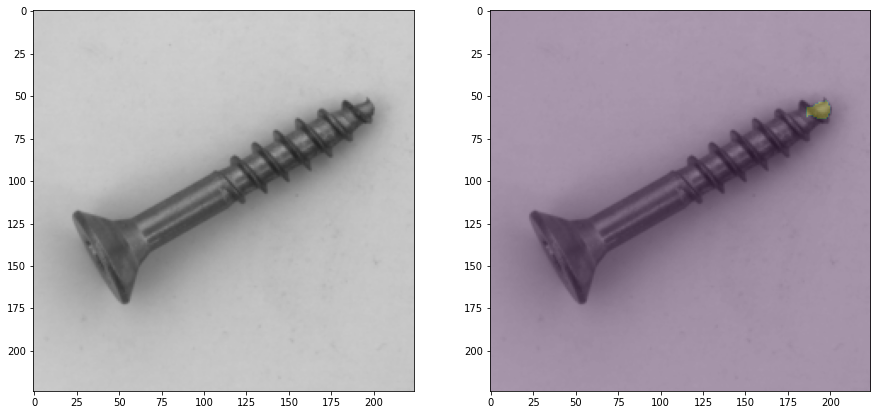

GT: good - Anomaly: False


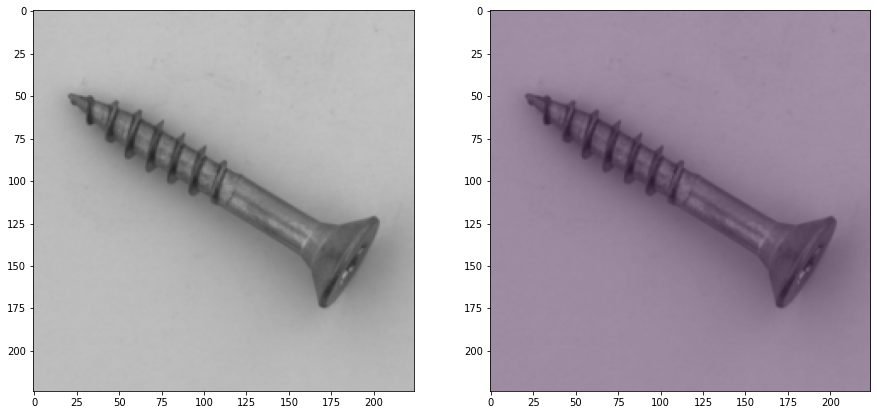

GT: anomaly - Anomaly: True


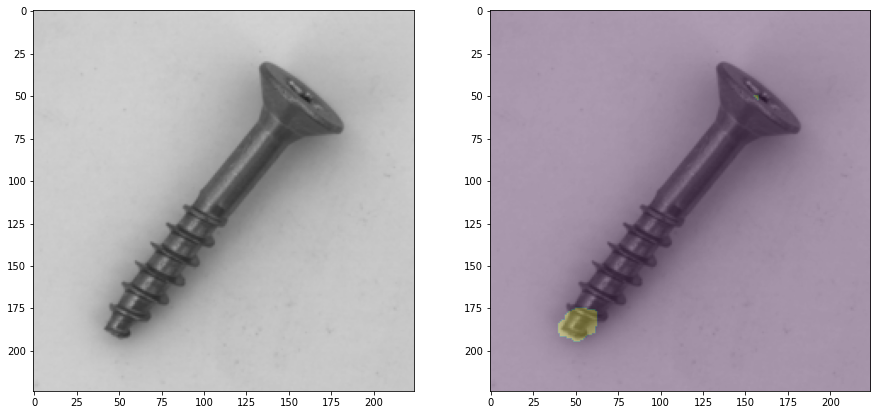

GT: anomaly - Anomaly: True


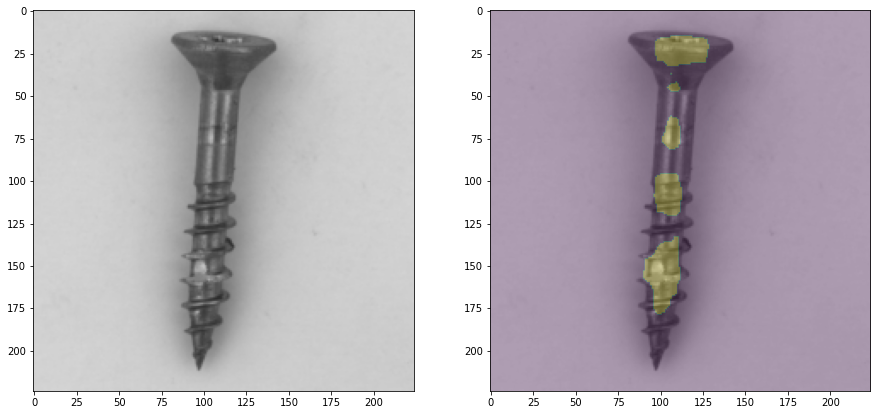

GT: anomaly - Anomaly: True


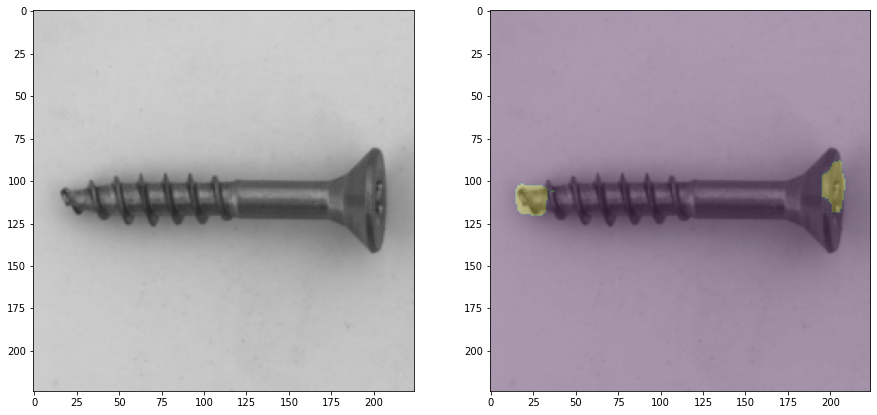

GT: anomaly - Anomaly: True


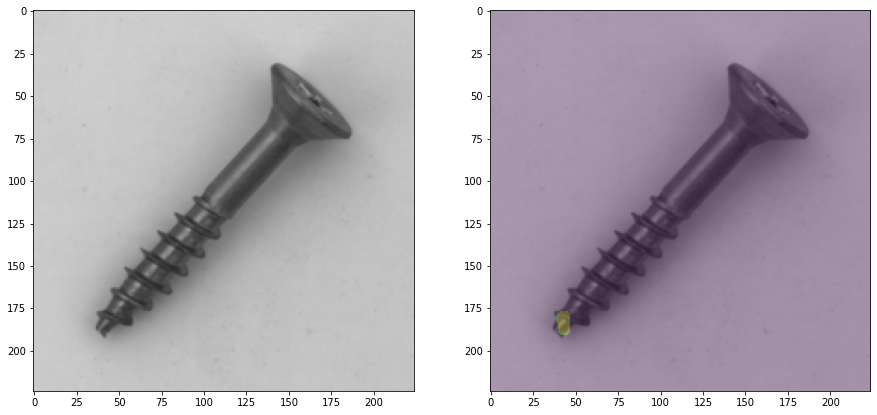

GT: good - Anomaly: False


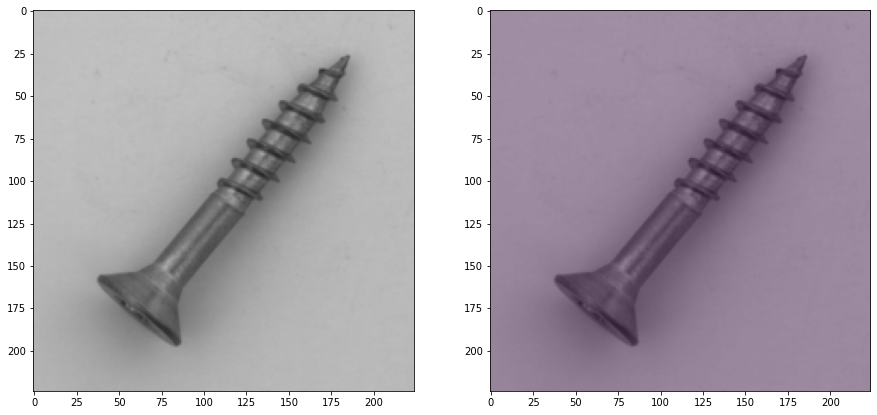

GT: good - Anomaly: False


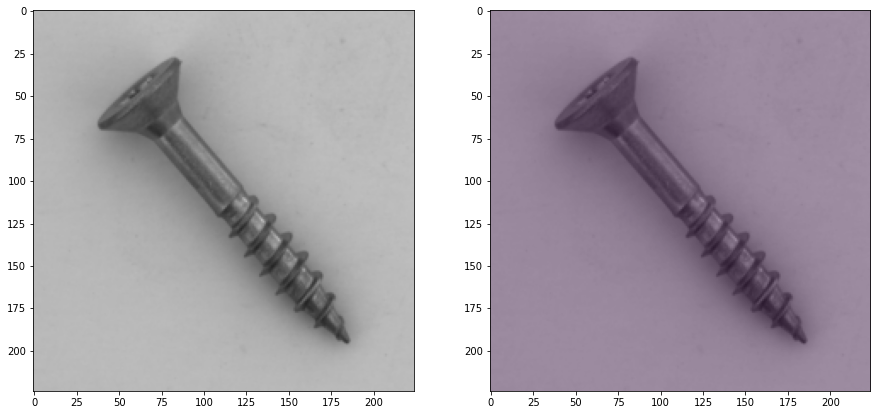

In [94]:
for idx in range(8):
    img = imgs[idx].permute(1, 2, 0).cpu().numpy()

    samp = score[idx].detach().cpu().numpy()
    samp = cv2.resize(samp, (224, 224))
    mask = np.where(samp>threshold, 1, 0)
    # plt.imshow(mask, cmap='gray')

    classes = ['good', 'anomaly']
    pred = prediction[idx]

    print(f'GT: {classes[labels[idx]]} - Anomaly: {pred}')

    f, axarr = plt.subplots(1,2, figsize=(15,15))
    axarr[0].imshow(img)
    axarr[1].imshow(mask)
    axarr[1].imshow(img, alpha = 0.75)
    plt.show()

In [24]:
import cv2

In [37]:
import matplotlib.pyplot as plt